In [28]:
### 日期转成工作日(0-4)
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

## 转成工作日数值 0-4 0周一 1周2 ...
def to_weekday(date):
    dt = datetime.strptime(date, "%Y-%m-%d")
    return dt.weekday()

stock_data = np.loadtxt('stock_data.csv',
                        delimiter=',',
                        # dtype = "U4, M8[D], f4, f4, f4, f4, i8",
                        dtype={
                            'names': ['type', 'weekday', 'open', 'high', 'low', 'close', 'volume'],
                            'formats': ['U4', 'int8', 'float32', 'float32', 'float32', 'float32', 'int64']
                        },
                        usecols=[0, 1, 2, 3, 4, 5, 6],  ##使用的列,必须和names的列匹配
                        unpack=False,  ## 是否拆包,就是降维
                        ## 转换器, 列位置: (x)->{}
                        converters={
                            1: lambda v: to_weekday(v),
                            2: lambda v: np.round(np.float32(v), decimals=2),
                            3: lambda v: np.round(np.float32(v), decimals=2),
                            4: lambda v: np.round(np.float32(v), decimals=2),
                            5: lambda v: np.round(np.float32(v), decimals=2),
                        },
                        skiprows=1,
                        encoding='utf8'
                        )


In [29]:
### 周一到周五,每个工作日的收盘价均值
wdays = stock_data['weekday']
## 更适合做视图解析 pivot
avg_p = np.zeros(5)
for wday in wdays:
    avg_p[wday] = np.mean(stock_data['close'][wday])

avg_p

for wday, avg_p in zip(['MON', 'TUE', 'WED', 'THU', 'FRI'], avg_p):
    print(wday, np.round(avg_p, 2))


MON 336.56
TUE 332.81
WED 373.71
THU 359.46
FRI 332.33


In [30]:
### 沿轴向统计
test = np.arange(1, 21).reshape(4, 5)
print(test)

row_mean = np.apply_along_axis(lambda row: np.mean(row), axis=1, arr=test)
col_mean = np.apply_along_axis(lambda col: np.mean(col), axis=0, arr=test)
row_mean, col_mean

[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]]


(array([ 3.,  8., 13., 18.]), array([ 8.5,  9.5, 10.5, 11.5, 12.5]))

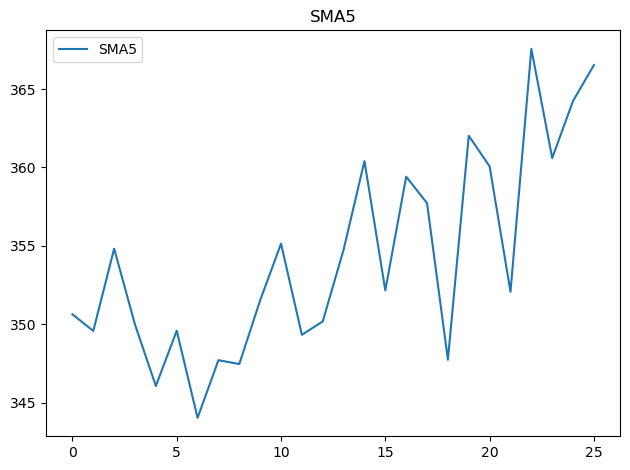

In [31]:
### 移动均线
##  从第五天开始,每天计算最近5天的收盘价均值
## (a+b+c+d+e)/5
## (b+c+d+e+f)/5
## ...
sma5 = np.zeros(stock_data['close'].shape[0] - 4)
for i in range(sma5.shape[0]):
    sma5[i] = np.mean(stock_data['close'][i:i+4])

plt.figure()
plt.title('SMA5')
plt.plot(sma5, label='SMA5')
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
### 卷积
## a:原始数组
## b:卷积核 -- 一般是对称,且是奇数, 卷积和一般为1
## mode: valid 有效卷积。 same 同维卷积。 full 全连接
a = np.array([1,2,3,4,5])
b = np.array([8,7,6])
np.convolve(a, b, mode='valid'), np.convolve(b, a, mode='same'), np.convolve(a, b, mode='full')

#            44 65 86               有效卷积(valid)
#         23 44 65 86 59 30         同维卷积(same)
#       8 23 44 65 86 59 30         完全卷积(full)
# 0  0  1  2  3  4  5  0  0
# 6  7  8 --------------------------b要先翻转? 如果不翻转,则8原本是第一个计算的,结果是6第一计算,不匹配(与for循环有关)
#    6  7  8                        对应位置乘积的和
#       6  7  8
#          6  7  8
#             6  7  8
#                6  7  8
#                   6  7  8
#

### --- 与5日均线 完全适配
# a = [a, b, c, d, e, f, g, h, i, j]
# b = [1/5, 1/5, 1/5, 1/5, 1/5]

(array([44, 65, 86]),
 array([23, 44, 65, 86, 59]),
 array([ 8, 23, 44, 65, 86, 59, 30]))

In [33]:
val = np.convolve(stock_data['close'], np.ones(5) / 5, mode='valid')
val.shape, val

((26,),
 array([346.97399292, 350.41999512, 354.72799683, 348.74400024,
        346.13800049, 345.98600464, 349.03800049, 346.72999878,
        350.50799561, 350.42599487, 353.27199097, 348.70799561,
        356.34199829, 357.52999878, 350.89000244, 356.77800293,
        362.37600098, 351.91599731, 352.18200073, 363.1039978 ,
        356.50200195, 359.79200439, 362.47400513, 364.88200073,
        361.67200317, 362.92600098]))

In [34]:
#### 加权卷积
### --- 与5日加权卷积--越靠近最后,权重越大
# a = [a, b, c, d, e, f, g, h, i, j]
# b = [1/5, 3/25, 5/25, 7/25, 9/25]

In [35]:
val = np.convolve(stock_data['close'], np.array([1/5, 3/25, 5/25, 7/25, 9/25]), mode='valid')
val.shape, val

((26,),
 array([398.69159302, 406.97999512, 414.97519409, 404.49599731,
        400.11079834, 403.22600708, 406.71160156, 399.92680054,
        405.03759521, 403.98679565, 412.0631897 , 404.90799561,
        414.35399536, 410.07879517, 404.42680176, 417.62760498,
        422.80320312, 405.98319702, 405.95800171, 423.48399536,
        413.27720215, 414.59840332, 419.80680542, 423.68200073,
        417.12320679, 424.69000244]))

In [36]:
#进阶版本 用exp函数
x = np.linspace(-1, 0, 5)
kernel = np.exp(x)[::-1]
kernel = kernel / np.sum(kernel)
val = np.convolve(stock_data['close'], kernel, mode='valid')
val, val.shape

(array([347.2141389 , 350.19913382, 353.03054724, 348.32897087,
        346.75155749, 343.325907  , 350.37148751, 347.67387606,
        352.67107846, 351.16344501, 351.24099908, 348.10563836,
        358.76779105, 361.47469848, 347.76340379, 356.45614644,
        362.87164632, 350.66304561, 355.04744335, 362.63706499,
        355.19100207, 364.50006763, 360.73409139, 366.50530404,
        361.73399497, 359.36356358]),
 (26,))

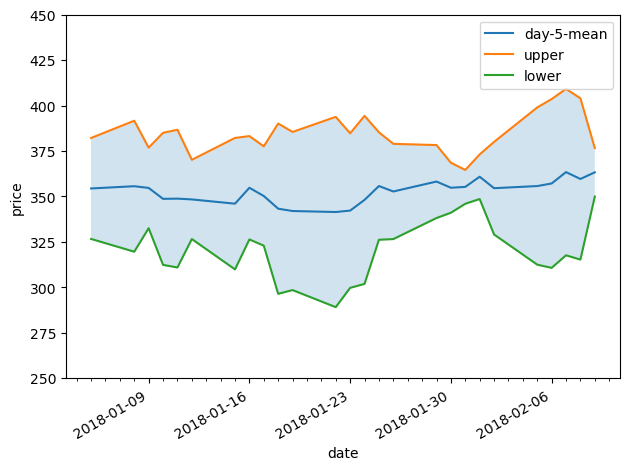

In [37]:
## 布林带
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

n = 30

## 构造股票数据
open = np.array(np.random.normal(350, 20, size=n))
close = np.array(np.random.normal(350, 20, size=n))
low = []
high = []
for i in range(n):
    min = open[i]
    max = close[i]
    if open[i] >= close[i]:
        min = close[i]
        max = open[i]
    val1 = np.random.uniform(min-20, max+20, 1)
    if val1 < min:
        val2 = np.random.uniform(min, max+20, 1)
    if val1 > max:
        val2 = np.random.uniform(min-20, max, 1)

    if val1 < val2:
        low.append(val1)
        high.append(val2)
    else:
        low.append(val2)
        high.append(val1)

data = pd.DataFrame({
    'type': np.array(['AAPL' for _ in range(n)]),
    'date': np.array(pd.date_range(start='2018-01-01', periods=n, freq='B')),
    'open': open,
    'high': np.array(high).reshape(n),
    'low': np.array(low).reshape(n),
    'close': close,
    'volume': np.array(np.random.randint(1000000, 3000000, size=n)),
}, columns=['type', 'date', 'open', 'high', 'low', 'close', 'volume'])

data.to_csv('stock_data.csv', index=False)

## 5日均值
day_5_mean = np.convolve(data['close'], np.ones(5)/5, mode='valid')
## 布林带
stds_5 = np.array([np.std(data['close'][i:i+4]) for i in range(day_5_mean.shape[0])])
upper = day_5_mean + 2 * stds_5
lower = day_5_mean - 2 * stds_5

plt.figure()
plt.plot(data['date'][4:], day_5_mean, label='day-5-mean')
plt.plot(data['date'][4:], upper, label='upper')
plt.plot(data['date'][4:], lower, label='lower')
plt.fill_between(data['date'][4:], upper, lower, upper > lower, alpha=0.2)
ax = plt.gca()
ax.xaxis.set_major_locator(md.WeekdayLocator())
ax.xaxis.set_minor_locator(md.DayLocator())
plt.legend()
plt.ylim(250, 450)
plt.xlabel('date')
plt.ylabel('price')
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

### 线性预测

前提,假设关系是线性关系!!!
a b c d e f g h

ax + by + cz = d

bx + cy + dz = e

cx + dy + ez = f

dx + ey + fz = ?

$\begin{bmatrix} a & b & c \\ b & c & d \\ c & d & e \end{bmatrix}$ x $\begin{bmatrix} x \\ y \\ z\end{bmatrix}$ = $\begin{bmatrix} d \\ e \\ f \end{bmatrix}$

通过前三项,预设第四项,依次往后推

x = np.linalg.lstsq(A, B)[0]

(30,)
(25,)
[   362.91486585    150.51759965    330.12363241    331.45041198
    398.34209118    626.25186675 -91000.37747403    366.34396088
    101.36522132    200.38552024    301.75576898    377.44352816
    374.80205096    297.44131391    346.5711003     380.45551418
    380.82137042    124.96482706    356.4187362     379.1245206
    400.10016909    292.8808297     387.08567029    289.90214892
    279.27073663]


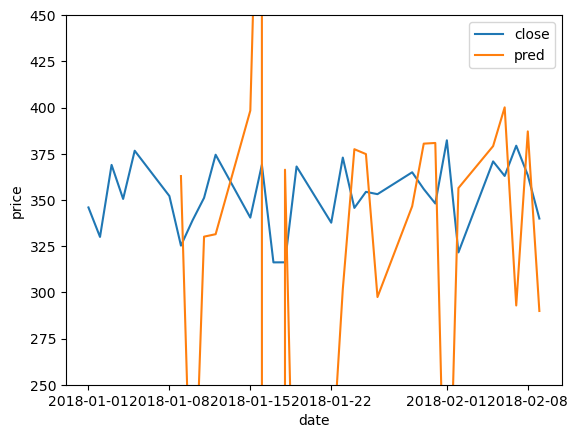

In [38]:
## 线性模型和线性拟合
## 预测收盘价--线性的!!!

n = 3
close_prices = data['close']
print(close_prices.shape)

pred_prices = np.zeros(close_prices.shape[0] - 2*n + 1)
print(pred_prices.shape)
for i in range(pred_prices.shape[0]):
    # 构造矩阵A 和 结果矩阵B
    A = np.zeros((n, n))
    for j in range(n):
        A[j] = close_prices[i+j: i +j + n]
    B = close_prices[n + i :2*n +i]
    # print(A, B , sep='\n')
    X = np.linalg.lstsq(A, B)[0] ## 预测的线性参数
    # print(X)
    pred = B.dot(X)
    # print(pred_prices, close_prices[2*n])
    pred_prices[i] = pred
print(pred_prices)

plt.figure()
plt.plot(data['date'], data['close'], label='close')
plt.plot(data['date'][2*n:], pred_prices[:-1], label='pred')
plt.xlabel('date')
plt.ylabel('price')
plt.ylim(250, 450)
plt.legend()
plt.show()

## 线性拟合
[$x_1, y_1], [x_2, y_2], ... , [x_n, y_n$]
根据线性 $y=kx + b$, 得到:

$y_1 = k * x_1$

$y_2 = k * x_2$

...

$y_n = k * x_n$

$\begin{bmatrix}
    x_1 & 1 \\
    x_2 & 1 \\
      ... \\
    x_n & 1 \\
\end{bmatrix}$ x $\begin{bmatrix}k \\ b\end{bmatrix}$=
$\begin{bmatrix}
    y_1 \\
    y_2 \\
    ... \\
    y_n \\
\end{bmatrix}$

In [ ]:
## 线性拟合--求k和b
trend_point = ( data['close'] + data['high'] + data['low'] ) / 3
## 构造A B矩阵,求得k,b
days = data['date'].astype(np.int64)
A = np.ones((trend_point.shape[0], 2)).T
A[0] = days
A = A.T
X = np.linalg.lstsq(A, trend_point)[0]
k = X[0]
b = X[1]

line = days * k + b

plt.figure()
plt.plot(data['date'], line, label='trend line')
plt.scatter(data['date'], trend_point, label='trend')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
plt.show()

$X = [x_1,x_2,...,x_n]$  - 自变量

$Y = [y_1,y_2,...,y_n]$ - 实际函数值

$\hat{Y} = [\hat{y_1}, \hat{y_2}, ..., \hat{y_n}]$ - 拟合函数值

$P = [p_0,p_1,...,p_n]$ - 拟合系数


## np的拟合函数
np.polyfit(X, Y, 最高次幂) -> P

## 根据系数P和坐标X,求预测值Y_hat
np.polyval(P, X) -> $\hat{Y}$

## 求导函数系数
np.polyder(P) -> Q

## 求多项式的根(与X轴的焦点横坐标)
xs = np.roots(Q)

## 两个多项式函数的差函数系数,可以求函数交点
y = y1 - y2
- 当求roots时 y=0,即求y1, y2的交点
- xs = np.ploysub(P1, P2)

p:  [ 4.43113154e-06 -2.33427709e-01  4.09891476e+03 -2.39918690e+07]
y:  [-0.01669199 -0.01306186 -0.00472535 -0.0027092  -0.00103007  0.00033861
  0.00142345  0.00324071  0.00345599  0.00352035  0.00346039  0.00330268
  0.00250894  0.00222611  0.00197846  0.0017926   0.0016951   0.00219862
  0.00272043  0.00346353  0.00445452  0.00571996]
[17542 17543 17546 17547 17548 17549 17550 17553 17554 17555 17556 17557
 17560 17561 17562 17563 17564 17567 17568 17569 17570 17571]


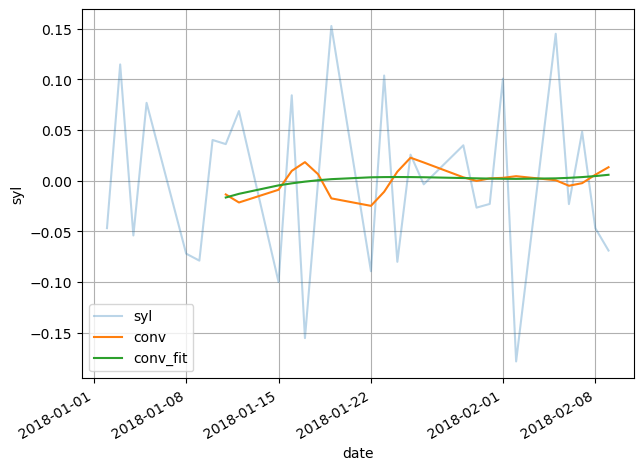

In [40]:
### 数据平滑(降噪 + 拟合)==》平滑曲线的目的
### 收益率 = (后一天收盘价 - 前一天收盘价) / 前一天收盘价
close_prices = np.array(data['close'])
dates = np.array(data['date'])
## 计算收益率
result = np.diff(close_prices) / close_prices[-1:]

## 使用卷积降噪
kernel = np.hanning(8) ## 钟型数组
kernel /= kernel.sum() ## 全部卷积和=1
conv_result = np.convolve(result, kernel, mode='valid')

## 对降噪曲线进行多项式拟合 -- 再次平滑
x = dates.astype('M8[D]').astype(int)[8:]
p = np.polyfit(x, conv_result, 3)
print("p: ", p)
y = np.polyval(p, x)
print("y: ", y)
print(x)

plt.figure()
plt.plot(dates[1:], result, label='syl', alpha=0.3)
## 卷积降噪曲线
plt.plot(dates[8:], conv_result, label='conv')
plt.plot(x, y, label='conv_fit')
plt.tight_layout()
plt.grid()
plt.xlabel('date')
plt.ylabel('syl')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()



In [ ]:
## 前后差值函数
arr = np.array([1,3,7,0,8,6])
## diff效果就是(后一项-前一项)
np.diff(arr)

In [42]:
## 符号函数
arr = np.array([[1, 2, -3], [4, 5, 0], [7, -8, 9]])
print(np.sign(arr))

[[ 1  1 -1]
 [ 1  1  0]
 [ 1 -1  1]]


In [43]:
## 分支选择
volumes = np.array([
    [100, -10, 0, 23],
    [0, 10, -20, -2],
    [3, -1, 2, -8],
    [-50, 55, 5, 44],
])
colors = np.piecewise(volumes, [volumes>0, volumes<=0], [1, -1])
print(colors)
colors2 = np.select([volumes>0, volumes<=0], ['green', 'red'], default='green')
print(colors2)


[[ 1 -1 -1  1]
 [-1  1 -1 -1]
 [ 1 -1  1 -1]
 [-1  1  1  1]]
[['green' 'red' 'red' 'green']
 ['red' 'green' 'red' 'red']
 ['green' 'red' 'green' 'red']
 ['red' 'green' 'green' 'green']]


In [44]:
# 输入数组
x = np.array([-5, 3, 15, 0, 12])

# 定义条件
condlist = [x < 0, (x >= 0) & (x < 10), x >= 10]

# 定义对应的颜色函数（这里用 lambda 返回字符串）
funclist = [
    lambda x: x**2,    # x < 0
    lambda x: x+10,  # 0 <= x < 10
    lambda x: x**3    # x >= 10
]

# 使用 np.piecewise --funclist只能返回数值型,返回字符串类型,报错
colors = np.piecewise(x, condlist, funclist)
print(colors)

# 使用np.select --default必须给值
x = np.array([-5, 3, 15, 0, 12])
condlist = [x < 0, (x >= 0) & (x < 10), x >= 10]
choicelist = ['green', 'red', 'blue']
colors2 = np.select(condlist, choicelist, default='blue')
print(colors2)


[  25   13 3375   10 1728]
['green' 'red' 'blue' 'red' 'blue']


In [45]:
### 矢量化函数
import math as m
def foo(x, y):
    return m.sqrt(x**2 + y**2) ## m.sqrt是标量函数,只能接受标量,不能接受数组

print(foo(1, 2))
a=np.array([1,2,3])
b=np.array([4,5,6])
# print(foo(a, b)) ## 报错了

foo_ver = np.vectorize(foo) ## 矢量化函数,就可以了,但本质只是循环调用,底层没有性能优化,和原生的np.sqrt比不了
print(foo_ver(a,b))
print(foo_ver(a, 2)) ## 可以数组和标量一起,这样会广播

### 另一种矢量化方法
foo_ff = np.frompyfunc(foo, 2, 1)
print(foo_ff(a,b))
print(foo_ff(a, 2))

2.23606797749979
[4.12310563 5.38516481 6.70820393]
[2.23606798 2.82842712 3.60555128]
[4.123105625617661 5.385164807134504 6.708203932499369]
[2.23606797749979 2.8284271247461903 3.605551275463989]


In [46]:
### 矩阵 -- 知道就好了,它是np.ndarray的子类,具备矩阵的一些运算特效,同时拥有多位数组的操作特性
### 比如矩阵乘法运算,和普通的数组乘法运算是不同的
### 矩阵时行列相乘, 数组时对应位置相乘

arr_a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
arr_b = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(arr_a * arr_b)

##copy默认只是True
matrix_a = np.matrix(arr_a)
matrix_b = np.matrix(arr_b, copy=True)
print(matrix_a * matrix_b)

matrix_c = np.matrix(arr_a, copy=False)
matrix_c[0, 0] = 9999
## matrix_c和arr_a都修改了,浅拷贝
## matrix_a没有修改,深拷贝
print(matrix_c, arr_a, matrix_a)

## 默认浅拷贝
matrix_d = np.asmatrix(matrix_b)
matrix_d[0, 0] = 9999
print(matrix_d, arr_b, matrix_b)

matrix_e = np.asmatrix('1 2 3; 4 5 6; 7 8 9', dtype=np.float64)
print(matrix_e)
print(matrix_e.T)
print(matrix_e * matrix_e)
print(matrix_e.I) ## 逆矩阵


[[ 1  4  9]
 [16 25 36]
 [49 64 81]]
[[ 30  36  42]
 [ 66  81  96]
 [102 126 150]]
[[9999    2    3]
 [   4    5    6]
 [   7    8    9]] [[9999    2    3]
 [   4    5    6]
 [   7    8    9]] [[1 2 3]
 [4 5 6]
 [7 8 9]]
[[9999    2    3]
 [   4    5    6]
 [   7    8    9]] [[1 2 3]
 [4 5 6]
 [7 8 9]] [[9999    2    3]
 [   4    5    6]
 [   7    8    9]]
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
[[1. 4. 7.]
 [2. 5. 8.]
 [3. 6. 9.]]
[[ 30.  36.  42.]
 [ 66.  81.  96.]
 [102. 126. 150.]]
[[ 3.15251974e+15 -6.30503948e+15  3.15251974e+15]
 [-6.30503948e+15  1.26100790e+16 -6.30503948e+15]
 [ 3.15251974e+15 -6.30503948e+15  3.15251974e+15]]


In [47]:
import numpy as np

# 定义一个 2x2 矩阵
A = np.matrix([[4, 7], [2, 6]])
print("原始矩阵 A:")
print(A)

# 获取逆矩阵
A_inv = A.I
print("逆矩阵 A⁻¹:")
print(A_inv)

# 验证 A * A⁻¹ = I
identity = A * A_inv
print("A * A⁻¹:")
print(identity)

## AB=E(E为单位矩阵,则称B为A的逆矩阵) --单位矩阵是一个方阵,且对角线是1,其他都为0
x=np.asmatrix('1 2 3; 4 2 6; 7 8 5')
print(x)
print(x.I)
print(x * x.I)

原始矩阵 A:
[[4 7]
 [2 6]]
逆矩阵 A⁻¹:
[[ 0.6 -0.7]
 [-0.2  0.4]]
A * A⁻¹:
[[ 1.00000000e+00 -1.11022302e-16]
 [ 1.11022302e-16  1.00000000e+00]]
[[1 2 3]
 [4 2 6]
 [7 8 5]]
[[-0.63333333  0.23333333  0.1       ]
 [ 0.36666667 -0.26666667  0.1       ]
 [ 0.3         0.1        -0.1       ]]
[[ 1.00000000e+00  1.38777878e-17 -2.77555756e-17]
 [ 1.11022302e-16  1.00000000e+00  5.55111512e-17]
 [ 3.88578059e-16 -1.24900090e-16  1.00000000e+00]]


In [48]:
A=np.matrix([[3, 3.2], [3.5, 3.6]])
B=np.matrix([[118.4], [135.2]])
x = np.linalg.solve(A, B)
print(x)

[[16.]
 [22.]]


In [49]:
## 裁剪
arr = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
arr.clip(min=3, max=6)

array([[3, 3, 3],
       [4, 5, 6],
       [6, 6, 6]])

In [50]:
## 压缩
a = np.arange(100)
print(a.compress(a % 3 == 0))

[ 0  3  6  9 12 15 18 21 24 27 30 33 36 39 42 45 48 51 54 57 60 63 66 69
 72 75 78 81 84 87 90 93 96 99]


In [53]:
a = np.arange(1,100)
np.add(a, a)
np.add.reduce(a) ##累加和
np.add.accumulate(a) ## 累加过程
np.add.outer([10, 20, 30], a) ## 外和
np.outer([10, 20, 30], a)  ## 外积
np.prod([1,2,3,4]) ## 累乘
np.cumprod([1,2,3,4]) ## 累乘过程
np.true_divide([1,2,3,4], [2,2,2,2]) ## 除法--列表对象就可以
np.divide([1,2,3,4], [2,2,2,2]) ## 除法 -- 列表即可
np.floor_divide([1,2,3,4], [2,2,2,2]) ## 地板取整 -- 列表即可
np.ceil(np.array([1,2,3,4]) / np.array([2,2,2,2])) ## 天花板取整 --必须是数组对象
np.trunc(np.array([1,2,3,4]) / np.array([2,2,2,2])) ##删除小数 --必须是数组对象
np.round(np.array([1,2,3,4]) / np.array([2,2,2,2])) ##四舍五入--必须是数组对象

array([[  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
         120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
         230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
         340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
         450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
         560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
         670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
         780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
         890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990],
       [  20,   40,   60,   80,  100,  120,  140,  160,  180,  200,  220,
         240,  260,  280,  300,  320,  340,  360,  380,  400,  420,  440,
         460,  480,  500,  520,  540,  560,  580,  600,  620,  640,  660,
         680,  700,  720,  740,  760,  780,  800,  820,  840,  860,  880,
         900,  920,  940,  960,  980,

In [54]:
## 帮助工具
help(np.add)

Help on ufunc:

add = <ufunc 'add'>
    add(x1, x2, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature])

    Add arguments element-wise.

    Parameters
    ----------
    x1, x2 : array_like
        The arrays to be added.
        If ``x1.shape != x2.shape``, they must be broadcastable to a common
        shape (which becomes the shape of the output).
    out : ndarray, None, or tuple of ndarray and None, optional
        A location into which the result is stored. If provided, it must have
        a shape that the inputs broadcast to. If not provided or None,
        a freshly-allocated array is returned. A tuple (possible only as a
        keyword argument) must have length equal to the number of outputs.
    where : array_like, optional
        This condition is broadcast over the input. At locations where the
        condition is True, the `out` array will be set to the ufunc result.
        Elsewhere, the `out` array will retain its or

In [55]:
### 位运算
a = np.arange(1, 10)
b = np.array([1, 2, 0, 0, 1, 0, 0, 1, 0])
np.bitwise_or(a, b)
np.bitwise_and(a, b)
np.bitwise_xor(a, b)
np.bitwise_count(a)
np.bitwise_not(a)
np.bitwise_invert(a)
np.bitwise_left_shift(a, b)
np.bitwise_right_shift(a, b)
binary_strings = [bin(x)[2:].zfill(8) for x in a]
print(binary_strings)

['00000001', '00000010', '00000011', '00000100', '00000101', '00000110', '00000111', '00001000', '00001001']


In [56]:
## where条件筛选
a = np.arange(1, 10)
np.where(a > 4) ## 返回的是符合条件元素的索引
a[np.where(a > 4)]

array([5, 6, 7, 8, 9])